In [22]:
%load_ext autoreload
%autoreload 2

import sys
import os
current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))
import glob
                 
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from lrr_annot.loader import Loader
from lrr_annot.analyzer import Analyzer, compute_lrr_discrepancy, compute_lrr_discrepancy_arithmetic, compute_laplacian_circular_coords
from lrr_annot.plotter import plot_regression, plot_residue_annotations_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in LRR-Predict results

In [2]:
res = pd.read_csv("../data/col-0-nlrome.csv", sep="\t")
labels = [s.split("Athaliana_")[1] for s in res["annotation"].values]
starts = [int(s) for s in res["start"].values]
predictions = {}
for l, s in zip(labels, starts):
    l = l.replace("_", ".")
    if not l in predictions:
        predictions[l] = []
    predictions[l].append(s)
for l, p in predictions.items():
    predictions[l] = np.sort(np.array(p, dtype=int))

proteins = set([s.split("/")[-1].split(".pdb")[0] for s in glob.glob("../data/a_thaliana_alpha/*")])
predictions = {key:value for key, value in predictions.items() if key in proteins}

### Compute parallel transport-based winding number and standard deviations

In [3]:
loader = Loader()
loader.load_batch("../data/a_thaliana_alpha")

Loading PDBs: 100%|███████████████████████████| 127/127 [00:08<00:00, 15.21it/s]


In [4]:
analyzer = Analyzer()
analyzer.load_structures(loader.structures)
analyzer.compute_windings()

Computing windings: 100%|█████████████████████| 127/127 [00:02<00:00, 52.38it/s]


In [5]:
analyzer.compute_regressions()

Computing regressions: 100%|██████████████████| 127/127 [05:07<00:00,  2.42s/it]


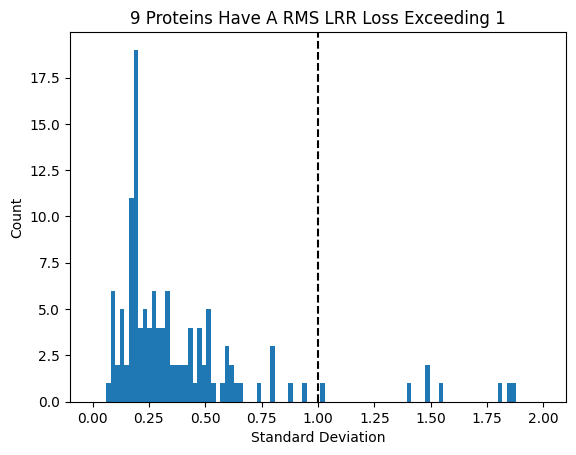

In [19]:
cutoff = 1
stds = np.array(list(analyzer.stds.values()))
plt.hist(stds, bins=np.linspace(0, 2, 100));
plt.axvline(cutoff, linestyle='--', c='k')
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
plt.title("{} Proteins Have A RMS LRR Loss Exceeding {}".format(np.sum(stds > cutoff), cutoff))
plt.savefig("StandardDeviationHist.svg", bbox_inches='tight')

### Compute Laplacian windings and compare discrepancies to parallel winding

In [7]:
analyzer.compute_lrr_windings_laplacian()

Computing Laplacian windings: 100%|███████████| 127/127 [00:05<00:00, 21.33it/s]


In [34]:
proteins_list = list(proteins)
discrepancies_parallel = np.zeros(len(proteins))
discrepancies_laplace = np.zeros(len(proteins))
for i, p in enumerate(proteins_list):
    winding = analyzer.windings[p]
    [a, b] = analyzer.lrr_endpoints[p]
    pred = predictions[p]
    lwinding = np.zeros_like(winding)
    lwinding[a:b] = analyzer.lrr_windings_laplacian[p]

    discrepancies_parallel[i] = compute_lrr_discrepancy(winding, pred, a, b)
    discrepancies_laplace[i] = compute_lrr_discrepancy(lwinding, pred, a, b)

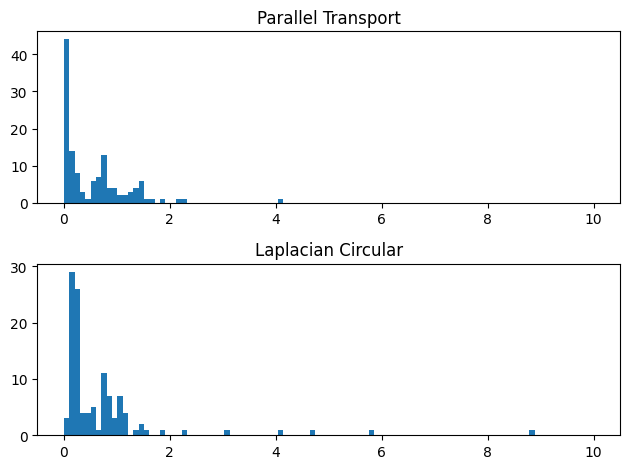

In [35]:
bins = np.linspace(0, 10, 100)
plt.subplot(211)
plt.hist(discrepancies_parallel, bins=bins);
plt.title("Parallel Transport")
plt.subplot(212)
plt.hist(discrepancies_laplace, bins=bins);
plt.title("Laplacian Circular")
#plt.legend(["Parallel transport", "Laplacian circular"])
plt.tight_layout()

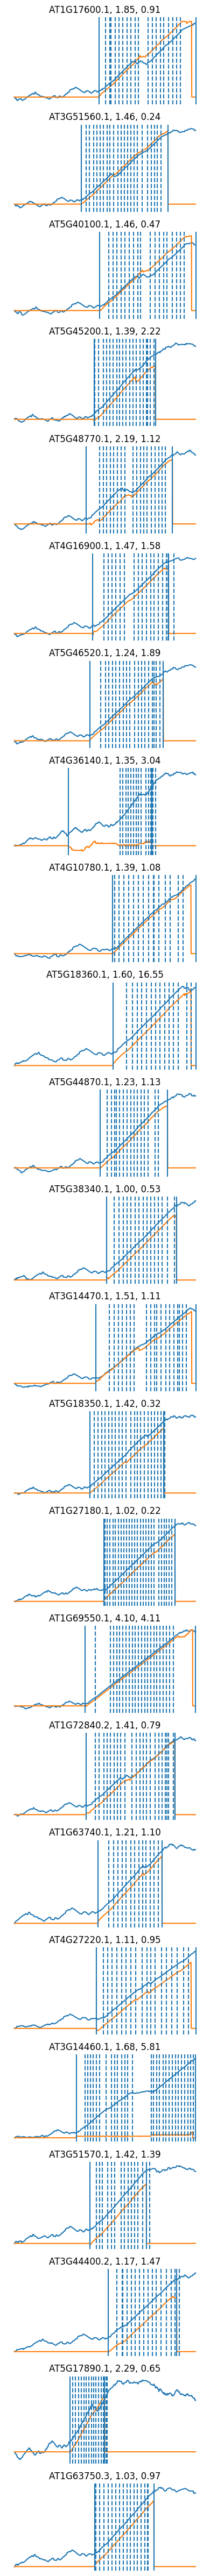

In [37]:
thresh = 1
n_above = np.sum(discrepancies_parallel > thresh)
plt.figure(figsize=(4, 2*n_above))
idx = 0
for i, (dp, dl) in enumerate(zip(discrepancies_parallel, discrepancies_laplace)):
    if dp > thresh:
        p = proteins_list[i]
        [a, b] = analyzer.lrr_endpoints[p]
        winding = analyzer.windings[p]
        lwinding = np.zeros_like(winding)
        lwinding[a:b] = analyzer.lrr_windings_laplacian[p]
        
        plt.subplot(n_above, 1, idx+1)
        plt.plot(winding)
        plt.plot(lwinding)
        plt.axvline(a)
        plt.axvline(b)
        plt.title("{}, {:.2f}, {:.2f}".format(p, dp, dl))


        for x in predictions[p]:
            plt.axvline(x, linestyle='--')
        
        plt.axis("off")
        
        idx += 1
plt.tight_layout()

#AT1G31540.2

In [ ]:
#p = list(proteins)[np.argmax(discrepancies_laplace)]
p = "AT1G31540.2"
res = compute_laplacian_circular_coords(analyzer.structures[p])
print(p)

In [ ]:
[a, b] = analyzer.lrr_endpoints[p]
pred = predictions[p]
winding = analyzer.windings[p]
lwinding = np.zeros_like(winding)
lwinding[a:b] = analyzer.lrr_windings_laplacian[p]

plt.plot(lwinding)
plt.plot(winding)
for x in pred:
    plt.axvline(x, linestyle='--')

print(compute_lrr_discrepancy(winding, pred, a, b))
print(compute_lrr_discrepancy(lwinding, pred, a, b))


In [ ]:
plt.imshow(res["v"][:, 0:20], aspect='auto', interpolation='none', cmap='magma')